In [ ]:
#mount drive, upload datasets, and import necessary packages
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip '/content/drive/MyDrive/GAN_Images_128.zip'

In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_GAN_data_128.zip'

Archive:  /content/drive/MyDrive/HAM10000_GAN_data_128.zip
  inflating: HAM10000_GAN_data_128.csv  


In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_metadata_augmented_gc.zip'

Archive:  /content/drive/MyDrive/HAM10000_metadata_augmented_gc.zip
  inflating: HAM10000_metadata_augmented.csv  


In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_images_augmented_gc.zip'

In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_metadata_gc.zip'

Archive:  /content/drive/MyDrive/HAM10000_metadata_gc.zip
  inflating: HAM10000_metadata       


In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_images_part_1_gc'

In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_images_part_2_gc'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import seaborn as sns
from PIL import Image
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, GlobalAveragePooling2D, ZeroPadding2D
from keras.applications import vgg16
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  


In [ ]:
#load all datasets and examine them

In [ ]:
md = pd.read_csv("/content/HAM10000_metadata")
md

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [ ]:
gans = pd.read_csv("/content/HAM10000_GAN_data_128.csv")
gans

,Unnamed: 0,image_id,dx
0,0,GAN_0000000.png,0
1,1,GAN_0000001.png,0
2,2,GAN_0000002.png,0
3,3,GAN_0000003.png,0
4,4,GAN_0000004.png,0
...,...,...,...
6001,6001,GAN_0006001.png,6
6002,6002,GAN_0006002.png,6
6003,6003,GAN_0006003.png,6
6004,6004,GAN_0006004.png,6


In [ ]:
mdau = pd.read_csv("/content/HAM10000_metadata_augmented.csv")
mdau

,Unnamed: 0,image_id,lesion_id,dx,dx_type,age,sex,localization,dataset
0,0,ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,Augmented
1,0,ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,Augmented
2,0,ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,Augmented
3,0,ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,Augmented
4,0,ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,Augmented
...,...,...,...,...,...,...,...,...,...
6001,0,ISIC_00277953,HAM_0001526,akiec,histo,70.0,male,ear,Augmented
6002,0,ISIC_00249133,HAM_0001495,akiec,histo,85.0,male,back,Augmented
6003,0,ISIC_00323293,HAM_0005027,akiec,histo,85.0,female,back,Augmented
6004,0,ISIC_00311983,HAM_0003422,akiec,histo,55.0,female,neck,Augmented


In [ ]:
#resize image
im_size = 224

In [ ]:
#create numerical labels based on disease categories then add them to datasets - done for all datasets (functions created to match mapping created for main metadata encoding)

In [ ]:
lab_enc = LabelEncoder()
lab_enc.fit(md['dx'])
LabelEncoder()
print(list(lab_enc.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
md['label'] = lab_enc.transform(md["dx"]) 

In [ ]:
def gan_dx(row):
  if row['dx'] == 0:
    return 'bkl'
  elif row['dx'] == 1:
    return 'nv'
  elif row['dx'] == 2:
    return 'df'
  elif row['dx'] == 3:
    return 'mel'
  elif row['dx'] == 4:
    return 'vasc'
  elif row['dx'] == 5:
    return 'bcc'
  elif row['dx'] == 6:
    return 'akiec'
  else:
    return None

gans['dx_s'] = gans.apply(lambda row: gan_dx(row), axis=1)
gans

,Unnamed: 0,image_id,dx,dx_s
0,0,GAN_0000000.png,0,bkl
1,1,GAN_0000001.png,0,bkl
2,2,GAN_0000002.png,0,bkl
3,3,GAN_0000003.png,0,bkl
4,4,GAN_0000004.png,0,bkl
...,...,...,...,...
6001,6001,GAN_0006001.png,6,akiec
6002,6002,GAN_0006002.png,6,akiec
6003,6003,GAN_0006003.png,6,akiec
6004,6004,GAN_0006004.png,6,akiec


In [ ]:
def gan_label(row):
  if row['dx_s'] == 'akiec':
    return 0
  elif row['dx_s'] == 'bcc':
    return 1
  elif row['dx_s'] == 'bkl':
    return 2
  elif row['dx_s'] == 'df':
    return 3
  elif row['dx_s'] == 'mel':
    return 4
  elif row['dx_s'] == 'nv':
    return 5
  elif row['dx_s'] == 'vasc':
    return 6
  else:
    return None

gans['label'] = gans.apply(lambda row: gan_label(row), axis=1)
gans

,Unnamed: 0,image_id,dx,dx_s,label
0,0,GAN_0000000.png,0,bkl,2
1,1,GAN_0000001.png,0,bkl,2
2,2,GAN_0000002.png,0,bkl,2
3,3,GAN_0000003.png,0,bkl,2
4,4,GAN_0000004.png,0,bkl,2
...,...,...,...,...,...
6001,6001,GAN_0006001.png,6,akiec,0
6002,6002,GAN_0006002.png,6,akiec,0
6003,6003,GAN_0006003.png,6,akiec,0
6004,6004,GAN_0006004.png,6,akiec,0


In [ ]:
def aug_label(row):
  if row['dx'] == 'akiec':
    return 0
  elif row['dx'] == 'bcc':
    return 1
  elif row['dx'] == 'bkl':
    return 2
  elif row['dx'] == 'df':
    return 3
  elif row['dx'] == 'mel':
    return 4
  elif row['dx'] == 'nv':
    return 5
  elif row['dx'] == 'vasc':
    return 6
  else:
    return None

mdau['label'] = mdau.apply(lambda row: aug_label(row), axis=1)
mdau

,Unnamed: 0,image_id,lesion_id,dx,dx_type,age,sex,localization,dataset,label
0,0,ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,Augmented,2
1,0,ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,Augmented,2
2,0,ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,Augmented,2
3,0,ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,Augmented,2
4,0,ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,Augmented,2
...,...,...,...,...,...,...,...,...,...,...
6001,0,ISIC_00277953,HAM_0001526,akiec,histo,70.0,male,ear,Augmented,0
6002,0,ISIC_00249133,HAM_0001495,akiec,histo,85.0,male,back,Augmented,0
6003,0,ISIC_00323293,HAM_0005027,akiec,histo,85.0,female,back,Augmented,0
6004,0,ISIC_00311983,HAM_0003422,akiec,histo,55.0,female,neck,Augmented,0


In [ ]:
#add image file paths to all datasets, then using the image paths, create ndarrays to represent all images

In [ ]:
fldr1 = '/content/HAM10000_images_part_1'
fldr2 = '/content/HAM10000_images_part_2'

im_paths = []

for i in md['image_id']:
  fid = i

  fn = '/' + fid + '.jpg'

  if os.path.isfile(fldr1 + fn) == True:
    im_paths.append(fldr1+fn)
  else:
    im_paths.append(fldr2+fn)   

In [ ]:
md['image_paths'] = im_paths
md

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,image_paths
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2,/content/HAM10000_images_part_2/ISIC_0031633.jpg
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033084.jpg
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033550.jpg
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033536.jpg
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0032854.jpg


In [ ]:
fldr_gan = '/content/GAN_Images_128'

im_path_gan = []

for i in gans['image_id']:
  fid_gan = i

  fn_gan = '/' + fid_gan 
  if os.path.isfile(fldr_gan+fn_gan) == True:
    im_path_gan.append(fldr_gan+fn_gan)
  else:
    im_path_gan.append('other')

In [ ]:
gans['image_paths'] = im_path_gan
gans

,Unnamed: 0,image_id,dx,dx_s,label,image_paths
0,0,GAN_0000000.png,0,bkl,2,/content/GAN_Images_128/GAN_0000000.png
1,1,GAN_0000001.png,0,bkl,2,/content/GAN_Images_128/GAN_0000001.png
2,2,GAN_0000002.png,0,bkl,2,/content/GAN_Images_128/GAN_0000002.png
3,3,GAN_0000003.png,0,bkl,2,/content/GAN_Images_128/GAN_0000003.png
4,4,GAN_0000004.png,0,bkl,2,/content/GAN_Images_128/GAN_0000004.png
...,...,...,...,...,...,...
6001,6001,GAN_0006001.png,6,akiec,0,/content/GAN_Images_128/GAN_0006001.png
6002,6002,GAN_0006002.png,6,akiec,0,/content/GAN_Images_128/GAN_0006002.png
6003,6003,GAN_0006003.png,6,akiec,0,/content/GAN_Images_128/GAN_0006003.png
6004,6004,GAN_0006004.png,6,akiec,0,/content/GAN_Images_128/GAN_0006004.png


In [ ]:
fldr_aug = '/content/HAM10000_images_augmented'

im_path_aug = []

for i in mdau['image_id']:
  fid_aug = i

  fn_aug = '/' + fid_aug + '.jpg'
  if os.path.isfile(fldr_aug+fn_aug) == True:
    im_path_aug.append(fldr_aug+fn_aug)
  else:
    im_path_aug.append('other')

In [ ]:
mdau['image_paths'] = im_path_aug
mdau

,Unnamed: 0,image_id,lesion_id,dx,dx_type,age,sex,localization,dataset,label,image_paths
0,0,ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,Augmented,2,/content/HAM10000_images_augmented/ISIC_002741...
1,0,ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,Augmented,2,/content/HAM10000_images_augmented/ISIC_002503...
2,0,ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,Augmented,2,/content/HAM10000_images_augmented/ISIC_002676...
3,0,ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,Augmented,2,/content/HAM10000_images_augmented/ISIC_002566...
4,0,ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,Augmented,2,/content/HAM10000_images_augmented/ISIC_003163...
...,...,...,...,...,...,...,...,...,...,...,...
6001,0,ISIC_00277953,HAM_0001526,akiec,histo,70.0,male,ear,Augmented,0,/content/HAM10000_images_augmented/ISIC_002779...
6002,0,ISIC_00249133,HAM_0001495,akiec,histo,85.0,male,back,Augmented,0,/content/HAM10000_images_augmented/ISIC_002491...
6003,0,ISIC_00323293,HAM_0005027,akiec,histo,85.0,female,back,Augmented,0,/content/HAM10000_images_augmented/ISIC_003232...
6004,0,ISIC_00311983,HAM_0003422,akiec,histo,55.0,female,neck,Augmented,0,/content/HAM10000_images_augmented/ISIC_003119...


In [ ]:
md['image'] = md['image_paths'].map(lambda x: np.asarray(Image.open(x).resize((im_size,im_size))))
md

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,image_paths,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0027419.jpg,"[[[187, 150, 192], [190, 154, 195], [192, 156,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025030.jpg,"[[[24, 13, 22], [25, 13, 23], [24, 14, 23], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0026769.jpg,"[[[186, 127, 135], [188, 129, 137], [191, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025661.jpg,"[[[23, 11, 15], [24, 11, 18], [24, 10, 19], [2..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2,/content/HAM10000_images_part_2/ISIC_0031633.jpg,"[[[125, 83, 105], [132, 89, 112], [138, 93, 11..."
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033084.jpg,"[[[115, 92, 101], [108, 92, 96], [108, 91, 98]..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033550.jpg,"[[[4, 6, 3], [5, 6, 3], [6, 6, 5], [7, 8, 4], ..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033536.jpg,"[[[105, 92, 96], [109, 102, 103], [118, 109, 1..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0032854.jpg,"[[[156, 115, 138], [158, 117, 138], [160, 121,..."


In [ ]:
mdau['image'] = mdau['image_paths'].map(lambda x: np.asarray(Image.open(x).resize((im_size,im_size))))
mdau

,Unnamed: 0,image_id,lesion_id,dx,dx_type,age,sex,localization,dataset,label,image_paths,image
0,0,ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,Augmented,2,/content/HAM10000_images_augmented/ISIC_002741...,"[[[240, 240, 240], [240, 240, 240], [240, 240,..."
1,0,ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,Augmented,2,/content/HAM10000_images_augmented/ISIC_002503...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,0,ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,Augmented,2,/content/HAM10000_images_augmented/ISIC_002676...,"[[[39, 39, 39], [39, 39, 39], [39, 39, 39], [3..."
3,0,ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,Augmented,2,/content/HAM10000_images_augmented/ISIC_002566...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,0,ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,Augmented,2,/content/HAM10000_images_augmented/ISIC_003163...,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
6001,0,ISIC_00277953,HAM_0001526,akiec,histo,70.0,male,ear,Augmented,0,/content/HAM10000_images_augmented/ISIC_002779...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
6002,0,ISIC_00249133,HAM_0001495,akiec,histo,85.0,male,back,Augmented,0,/content/HAM10000_images_augmented/ISIC_002491...,"[[[115, 80, 85], [176, 116, 126], [182, 111, 1..."
6003,0,ISIC_00323293,HAM_0005027,akiec,histo,85.0,female,back,Augmented,0,/content/HAM10000_images_augmented/ISIC_003232...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
6004,0,ISIC_00311983,HAM_0003422,akiec,histo,55.0,female,neck,Augmented,0,/content/HAM10000_images_augmented/ISIC_003119...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [ ]:
gans['image'] = gans['image_paths'].map(lambda x: np.asarray(Image.open(x).resize((im_size,im_size))))
gans

,Unnamed: 0,image_id,dx,dx_s,label,image_paths,image
0,0,GAN_0000000.png,0,bkl,2,/content/GAN_Images_128/GAN_0000000.png,"[[[126, 87, 97], [134, 91, 106], [146, 97, 120..."
1,1,GAN_0000001.png,0,bkl,2,/content/GAN_Images_128/GAN_0000001.png,"[[[106, 69, 78], [109, 67, 83], [113, 64, 90],..."
2,2,GAN_0000002.png,0,bkl,2,/content/GAN_Images_128/GAN_0000002.png,"[[[147, 101, 114], [159, 109, 129], [178, 122,..."
3,3,GAN_0000003.png,0,bkl,2,/content/GAN_Images_128/GAN_0000003.png,"[[[97, 71, 78], [93, 66, 77], [87, 57, 76], [8..."
4,4,GAN_0000004.png,0,bkl,2,/content/GAN_Images_128/GAN_0000004.png,"[[[131, 89, 99], [139, 94, 109], [153, 101, 12..."
...,...,...,...,...,...,...,...
6001,6001,GAN_0006001.png,6,akiec,0,/content/GAN_Images_128/GAN_0006001.png,"[[[157, 108, 120], [172, 121, 137], [197, 143,..."
6002,6002,GAN_0006002.png,6,akiec,0,/content/GAN_Images_128/GAN_0006002.png,"[[[158, 104, 117], [175, 117, 135], [202, 137,..."
6003,6003,GAN_0006003.png,6,akiec,0,/content/GAN_Images_128/GAN_0006003.png,"[[[161, 115, 126], [175, 124, 139], [196, 138,..."
6004,6004,GAN_0006004.png,6,akiec,0,/content/GAN_Images_128/GAN_0006004.png,"[[[139, 94, 104], [152, 101, 116], [172, 112, ..."


In [ ]:
#create test train split
#remove all augmentation images that are based on original images present in the testing set
#add gan images and augmentation images to the training set

In [ ]:
train, test = train_test_split(md, test_size=0.25, random_state=29, shuffle=True)

In [ ]:
og_im_id = []

for i in mdau['image_id']:
  stl = len(i)
  if stl == 13:
    og_im = i.rstrip(i[-1])
    og_im_id.append(og_im)
  else:
    og_im = i
    og_im_id.append(og_im)

In [ ]:
mdau['OG_Image_ID'] = og_im_id
mdau

,Unnamed: 0,image_id,lesion_id,dx,dx_type,age,sex,localization,dataset,label,image_paths,image,OG_Image_ID
0,0,ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,Augmented,2,/content/HAM10000_images_augmented/ISIC_002741...,"[[[240, 240, 240], [240, 240, 240], [240, 240,...",ISIC_0027419
1,0,ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,Augmented,2,/content/HAM10000_images_augmented/ISIC_002503...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",ISIC_0025030
2,0,ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,Augmented,2,/content/HAM10000_images_augmented/ISIC_002676...,"[[[39, 39, 39], [39, 39, 39], [39, 39, 39], [3...",ISIC_0026769
3,0,ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,Augmented,2,/content/HAM10000_images_augmented/ISIC_002566...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",ISIC_0025661
4,0,ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,Augmented,2,/content/HAM10000_images_augmented/ISIC_003163...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",ISIC_0031633
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6001,0,ISIC_00277953,HAM_0001526,akiec,histo,70.0,male,ear,Augmented,0,/content/HAM10000_images_augmented/ISIC_002779...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",ISIC_0027795
6002,0,ISIC_00249133,HAM_0001495,akiec,histo,85.0,male,back,Augmented,0,/content/HAM10000_images_augmented/ISIC_002491...,"[[[115, 80, 85], [176, 116, 126], [182, 111, 1...",ISIC_002491
6003,0,ISIC_00323293,HAM_0005027,akiec,histo,85.0,female,back,Augmented,0,/content/HAM10000_images_augmented/ISIC_003232...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",ISIC_0032329
6004,0,ISIC_00311983,HAM_0003422,akiec,histo,55.0,female,neck,Augmented,0,/content/HAM10000_images_augmented/ISIC_003119...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",ISIC_0031198


In [ ]:
cond = mdau['OG_Image_ID'].isin(test['image_id'])
mdau.drop(mdau[cond].index, inplace=True)

In [ ]:
aug = mdau.drop('OG_Image_ID', axis=1)
aug.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
aug_set = aug.sample(n=3000)
aug_set

,image_id,lesion_id,dx,dx_type,age,sex,localization,dataset,label,image_paths,image
5377,ISIC_00254111,HAM_0002158,akiec,histo,50.0,male,upper extremity,Augmented,0,/content/HAM10000_images_augmented/ISIC_002541...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
209,ISIC_0034070,HAM_0000087,bkl,histo,45.0,male,upper extremity,Augmented,2,/content/HAM10000_images_augmented/ISIC_003407...,"[[[255, 255, 253], [255, 254, 255], [255, 255,..."
1290,ISIC_00264172,HAM_0005663,df,consensus,30.0,male,lower extremity,Augmented,3,/content/HAM10000_images_augmented/ISIC_002641...,"[[[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], ..."
3277,ISIC_00254251,HAM_0002787,vasc,consensus,50.0,male,trunk,Augmented,6,/content/HAM10000_images_augmented/ISIC_002542...,"[[[11, 11, 11], [11, 11, 11], [11, 11, 11], [1..."
2724,ISIC_0029933,HAM_0007305,mel,histo,45.0,female,upper extremity,Augmented,4,/content/HAM10000_images_augmented/ISIC_002993...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
...,...,...,...,...,...,...,...,...,...,...,...
2144,ISIC_0026369,HAM_0006522,mel,histo,30.0,female,lower extremity,Augmented,4,/content/HAM10000_images_augmented/ISIC_002636...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4738,ISIC_00315391,HAM_0005302,bcc,histo,75.0,male,back,Augmented,1,/content/HAM10000_images_augmented/ISIC_003153...,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ..."
2741,ISIC_0026770,HAM_0002491,mel,histo,65.0,male,upper extremity,Augmented,4,/content/HAM10000_images_augmented/ISIC_002677...,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4613,ISIC_00263951,HAM_0005382,bcc,histo,50.0,female,back,Augmented,1,/content/HAM10000_images_augmented/ISIC_002639...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [ ]:
gan_set = gans.sample(n=3000)
gan_set

,Unnamed: 0,image_id,dx,dx_s,label,image_paths,image
5235,5235,GAN_0005235.png,6,akiec,0,/content/GAN_Images_128/GAN_0005235.png,"[[[131, 88, 98], [139, 90, 106], [152, 95, 118..."
4315,4315,GAN_0004315.png,5,bcc,1,/content/GAN_Images_128/GAN_0004315.png,"[[[139, 95, 106], [151, 103, 118], [169, 114, ..."
4090,4090,GAN_0004090.png,5,bcc,1,/content/GAN_Images_128/GAN_0004090.png,"[[[121, 78, 88], [130, 82, 97], [143, 89, 113]..."
835,835,GAN_0000835.png,0,bkl,2,/content/GAN_Images_128/GAN_0000835.png,"[[[119, 80, 90], [125, 83, 98], [135, 87, 110]..."
5774,5774,GAN_0005774.png,6,akiec,0,/content/GAN_Images_128/GAN_0005774.png,"[[[107, 73, 81], [111, 73, 87], [117, 73, 95],..."
...,...,...,...,...,...,...,...
3346,3346,GAN_0003346.png,4,vasc,6,/content/GAN_Images_128/GAN_0003346.png,"[[[167, 119, 130], [184, 131, 147], [211, 151,..."
2556,2556,GAN_0002556.png,3,mel,4,/content/GAN_Images_128/GAN_0002556.png,"[[[129, 89, 99], [135, 91, 106], [146, 94, 118..."
2599,2599,GAN_0002599.png,3,mel,4,/content/GAN_Images_128/GAN_0002599.png,"[[[72, 54, 58], [63, 45, 52], [50, 31, 43], [4..."
686,686,GAN_0000686.png,0,bkl,2,/content/GAN_Images_128/GAN_0000686.png,"[[[66, 50, 54], [56, 39, 47], [40, 23, 34], [3..."


In [ ]:
#standardize arrays and create arrays to represent output labels 

In [ ]:
trainX = np.array(train["image"].tolist())
trainX = trainX/225

ganX = np.array(gan_set["image"].tolist())
ganX = ganX/225

augX = np.array(aug_set["image"].tolist())
augX = augX/225

trg = np.concatenate((trainX, ganX), axis=0)
tr_in = np.concatenate((trg, augX), axis=0)
tr_in

array([[[[1.03555556, 0.89333333, 0.99555556],
         [1.02666667, 0.88888889, 1.02222222],
         [1.01777778, 0.88      , 1.01777778],
         ...,
         [0.93333333, 0.76888889, 0.84888889],
         [0.93333333, 0.78666667, 0.87555556],
         [0.93333333, 0.79555556, 0.88888889]],

        [[1.04      , 0.88444444, 1.        ],
         [1.02222222, 0.88888889, 1.00444444],
         [1.02666667, 0.89333333, 1.01333333],
         ...,
         [0.95555556, 0.79555556, 0.87111111],
         [0.94666667, 0.8       , 0.88444444],
         [0.94222222, 0.8       , 0.88888889]],

        [[1.03111111, 0.88      , 0.99555556],
         [1.02666667, 0.88444444, 1.01333333],
         [1.03111111, 0.89333333, 1.00888889],
         ...,
         [0.95111111, 0.79555556, 0.86666667],
         [0.94666667, 0.8       , 0.87555556],
         [0.95111111, 0.79111111, 0.88      ]],

        ...,

        [[1.03555556, 0.87555556, 0.99555556],
         [1.02666667, 0.87111111, 0.98222222]

In [ ]:
trainY = train['label']
trainY_dx = to_categorical(trainY, num_classes=7)

ganY = gan_set['label']
ganY_dx = to_categorical(ganY, num_classes=7)

augY = aug_set['label']
augY_dx = to_categorical(augY, num_classes=7)

trgy = np.concatenate((trainY_dx, ganY_dx), axis=0)
tr_out = np.concatenate((trgy, augY_dx), axis=0)
tr_out

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
testX = np.array(test["image"].tolist())
testX = testX/225

testY = test['label']
testY_dx = to_categorical(testY, num_classes=7)

In [ ]:
#model creation: 3 convolutional layers with pooling layers and dropout layers, then two dense layers ending in softmax activation

In [ ]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(im_size, im_size, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 256)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 256)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 128)       0

In [ ]:
#hyperparameters and model fitting
batch_size = 16 
epochs = 75

In [ ]:
mod_fit = model.fit(
    tr_in, tr_out,
    epochs=epochs,
    batch_size = batch_size,
    verbose=2)

Epoch 1/75
845/845 - 33s - loss: 1.3385 - acc: 0.5174 - 33s/epoch - 39ms/step
Epoch 2/75
845/845 - 20s - loss: 1.0038 - acc: 0.6385 - 20s/epoch - 24ms/step
Epoch 3/75
845/845 - 21s - loss: 0.8923 - acc: 0.6733 - 21s/epoch - 24ms/step
Epoch 4/75
845/845 - 20s - loss: 0.8423 - acc: 0.6910 - 20s/epoch - 24ms/step
Epoch 5/75
845/845 - 20s - loss: 0.8116 - acc: 0.7011 - 20s/epoch - 24ms/step
Epoch 6/75
845/845 - 20s - loss: 0.7831 - acc: 0.7142 - 20s/epoch - 24ms/step
Epoch 7/75
845/845 - 20s - loss: 0.7710 - acc: 0.7137 - 20s/epoch - 24ms/step
Epoch 8/75
845/845 - 20s - loss: 0.7414 - acc: 0.7268 - 20s/epoch - 24ms/step
Epoch 9/75
845/845 - 20s - loss: 0.7212 - acc: 0.7313 - 20s/epoch - 24ms/step
Epoch 10/75
845/845 - 20s - loss: 0.7096 - acc: 0.7364 - 20s/epoch - 24ms/step
Epoch 11/75
845/845 - 20s - loss: 0.6982 - acc: 0.7419 - 20s/epoch - 24ms/step
Epoch 12/75
845/845 - 20s - loss: 0.6836 - acc: 0.7438 - 20s/epoch - 24ms/step
Epoch 13/75
845/845 - 20s - loss: 0.6658 - acc: 0.7528 - 20s/

In [ ]:
#model accuracies and class wise accuracies and predictions

In [ ]:
mod_acc = model.evaluate(testX, testY_dx)
print('Test Accuracy: ', mod_acc[1])

79/79 [==============================] - 2s 21ms/step - loss: 1.6947 - acc: 0.6617
Test Accuracy:  0.6617411971092224


In [ ]:
y_preds = model.predict(testX)

79/79 [==============================] - 2s 18ms/step


In [ ]:
y_pred_classes = np.argmax(y_preds, axis=1)

In [ ]:
y_true = np.argmax(testY_dx, axis=1)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred_classes, target_names = ['Akiec', 'Bcc', 'Bkl', 'Df', 'Mel', 'Nv', 'Vasc'])
print(report)

              precision    recall  f1-score   support

       Akiec       0.38      0.11      0.17        91
         Bcc       0.24      0.17      0.20       132
         Bkl       0.29      0.35      0.32       271
          Df       0.17      0.20      0.18        30
         Mel       0.40      0.26      0.32       277
          Nv       0.79      0.86      0.82      1669
        Vasc       0.56      0.65      0.60        34

    accuracy                           0.66      2504
   macro avg       0.41      0.37      0.37      2504
weighted avg       0.64      0.66      0.64      2504



In [ ]:
def classwise_accuracy():
   a = pd.crosstab(y_true,y_pred_classes)
   print(a.max(axis=1)/a.sum(axis=1))
classwise_accuracy()

row_0
0    0.417582
1    0.363636
2    0.464945
3    0.366667
4    0.548736
5    0.856800
6    0.647059
dtype: float64


In [ ]:
#confusion matrix and percent misclassfied by disease categories

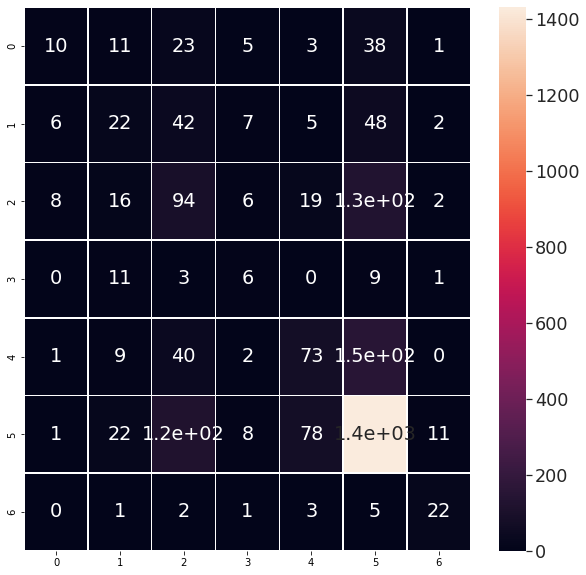

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [ ]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)

incorr_fraction = incorr_fraction.tolist()

incorr_fraction = [round(item, 2) for item in incorr_fraction]

incorr_fraction

[0.89, 0.83, 0.65, 0.8, 0.74, 0.14, 0.35]

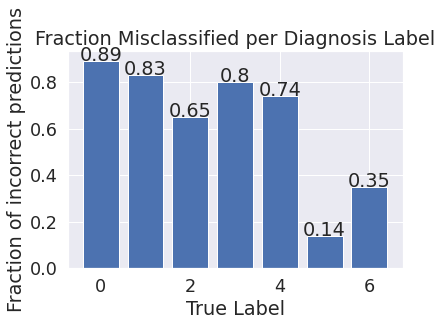

In [ ]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
  
if __name__ == '__main__':
  plt.bar(np.arange(7), incorr_fraction)
  addlabels(np.arange(7), incorr_fraction)
  plt.title("Fraction Misclassified per Diagnosis Label")
  plt.xlabel('True Label')
  plt.ylabel('Fraction of incorrect predictions')